# Variational AutoEncoders

Full Name: Amirparsa Bahrami

Student ID: 401101332


# Variational Autoencoder

In this notebook, you will implement a variational autoencoder and a conditional variational autoencoder with slightly different architectures and apply them to the popular MNIST handwritten dataset.

Load several useful packages that are used in this notebook:

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import random
import cv2
import matplotlib as mpl
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [2]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load MNIST Dataset


VAEs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the MNIST dataset, which has 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

To simplify our code here, we will use the PyTorch MNIST wrapper, which downloads and loads the MNIST dataset.

In [3]:
batch_size = 128

mnist_train = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.51MB/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



## Visualize dataset

It is always a good idea to look at examples from the dataset before working with it. Let's visualize the digits in the MNIST dataset. We have defined the function `show_images` to visualize the images.


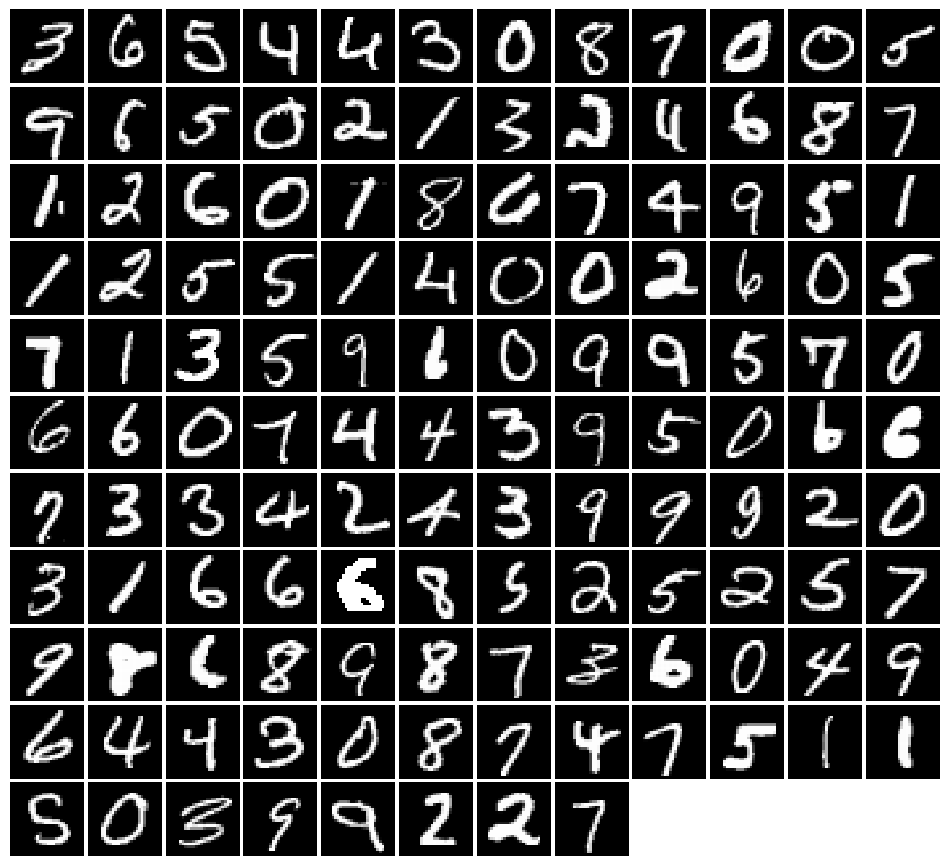

In [4]:
def show_images(images):
    images = torch.reshape(
        images, [images.shape[0], -1]
    )
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis("off")
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect("equal")
        plt.imshow(img.reshape([sqrtimg, sqrtimg]))
    return

data_iter = iter(loader_train)
imgs, _ = next(data_iter)
imgs = imgs.view(batch_size, 784)
show_images(imgs)

# Fully Connected VAE

Your first VAE implementation will consist solely of fully connected layers. You'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. In this section you'll define the Encoder and Decoder models in the VAE class and implement the reparametrization trick, forward pass, and loss function to train your first VAE.

## FC-VAE Forward

Complete the VAE class by writing the initialization and the forward pass. The forward pass should pass the input image through the encoder to calculate the estimation of mu and logvar, reparametrize to estimate the latent space z, and finally pass z into the decoder to generate an image.



In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device):
        super(VAE_MLP, self).__init__()
        self.device = device

        # ----------------------------------------------------
        # Encoder
        # ----------------------------------------------------
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # ----------------------------------------------------
        # Decoder
        # ----------------------------------------------------
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Since MNIST is 0..1, a sigmoid output is common
        )

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: z = mu + sigma * eps
        # where eps ~ N(0, I)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        z = mu + std * eps
        return z

    def forward(self, x):
        """
        Forward pass:
          1) encode x -> (mu, logvar)
          2) reparameterize to get z
          3) decode z -> reconstruction
        """
        # Flatten input: x is [batch_size, 1, 28, 28] => [batch_size, 784]
        x = x.view(x.size(0), -1)

        # Encode
        h_enc = self.encoder(x)
        mu = self.fc_mu(h_enc)
        logvar = self.fc_logvar(h_enc)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        recon = self.decoder(z)

        return recon, mu, logvar

## Loss Function

Complete the vae_loss function below

In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    """
    Computes the VAE loss = Reconstruction Loss + KL Divergence
    Here, we use binary cross-entropy as the reconstruction loss,
    assuming the input pixels are in [0,1].
    """
    # Flatten the data again to match recon's shape [N, 784]
    data = data.view(data.size(0), -1)

    # 1) Reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # 2) KL Divergence loss
    #    KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    #    We sum over latent dim, then average over batch.
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # We typically return the sum of these terms.
    # If you prefer average per batch, you can divide by batch size.
    total_loss = recon_loss + kl_loss
    return total_loss


## Train a model

Now that we have our VAE defined and loss function ready, lets train our model!

Complete the train_vae_mlp function to train the network.

In [7]:
def train_vae_mlp(model, train_loader, num_epochs=20, learning_rate=1e-3):
    model.to(model.device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(model.device)

            # Forward pass
            recon, mu, logvar = model(data)

            # Compute loss
            loss = vae_loss(recon, data, mu, logvar)

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss) / len(total_loss))
        print(f'VAE- Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

In [10]:
# TODO: Train VAE
latent_size = 20
hidden_dim = 400
VAE = VAE_MLP(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_size, device=device)

train_vae_mlp(VAE, loader_train, num_epochs=30, learning_rate=1e-3)


VAE- Epoch [1/30], Loss: 22966.852067474625

VAE- Epoch [2/30], Loss: 16543.698208800746

VAE- Epoch [3/30], Loss: 15130.119140625

VAE- Epoch [4/30], Loss: 14476.677179320246

VAE- Epoch [5/30], Loss: 14099.905306824252

VAE- Epoch [6/30], Loss: 13858.864489433094

VAE- Epoch [7/30], Loss: 13681.252213959002

VAE- Epoch [8/30], Loss: 13543.289515307826

VAE- Epoch [9/30], Loss: 13430.079293536324

VAE- Epoch [10/30], Loss: 13347.18646083734

VAE- Epoch [11/30], Loss: 13260.557489900508

VAE- Epoch [12/30], Loss: 13197.467750484107

VAE- Epoch [13/30], Loss: 13140.135402059963

VAE- Epoch [14/30], Loss: 13082.832749065172

VAE- Epoch [15/30], Loss: 13046.411366519766

VAE- Epoch [16/30], Loss: 13000.444882645566

VAE- Epoch [17/30], Loss: 12961.55275524172

VAE- Epoch [18/30], Loss: 12923.03905206664

VAE- Epoch [19/30], Loss: 12902.184263571715

VAE- Epoch [20/30], Loss: 12864.825700287127

VAE- Epoch [21/30], Loss: 12837.18556774172

VAE- Epoch [22/30], Loss: 12821.915197649572

VAE

## Visualize results

After training our VAE network, we're able to take advantage of its power to generate new training examples. This process simply involves the decoder: we intialize some random distribution for our latent spaces z, and generate new examples by passing these latent space into the decoder.

Run the cell below to generate new images! You should be able to visually recognize many of the digits, although some may be a bit blurry or badly formed. Our next model will see improvement in these results.

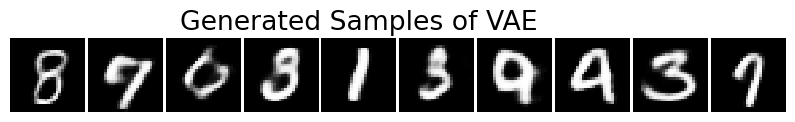

In [11]:
num_samples = 10
z = torch.randn(num_samples, latent_size).to(device=device)

VAE.eval()
samples = VAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    plt.axis('off')
    if i == 4:
      plt.title('Generated Samples of VAE')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28,28), cmap='Greys_r')

# Conditional FC-VAE

The second model you'll develop will be very similar to the FC-VAE, but with a slight conditional twist to it. We'll use what we know about the labels of each MNIST image, and *condition* our latent space and image generation on the specific class. Instead of $q_{\phi} (z|x)$ and $p_{\phi}(x|z)$ we have $q_{\phi} (z|x,c)$  and $p_{\phi}(x|z, c)$

This will allow us to do some powerful conditional generation at inference time. We can specifically choose to generate more 1s, 2s, 9s, etc. instead of simply generating new digits randomly.

## Define Network with class input

Your CVAE architecture should be the same as your FC-VAE architecture, except you'll now concatenate a one-hot label vector to both the x input (in our case, the flattened image dimensions) and the z latent space.

If the one-hot vector is called `c`, then `c[label] = 1` and `c = 0` elsewhere.

For the `CVAE_MLP` class use the same FC-VAE architecture implemented in the last network.


In [12]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes, device):
        super(CVAE_MLP, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # ----------------------------------------------------
        # Encoder
        # ----------------------------------------------------
        # The input to the encoder is [x, y_onehot], dimension = 784 + num_classes
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # This classifier will predict the class from the latent features
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # ----------------------------------------------------
        # Decoder
        # ----------------------------------------------------
        # The decoder sees [z, y_onehot], dimension = latent_dim + num_classes
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        z = mu + std * eps
        return z

    def forward(self, x, y_onehot):
        """
        Forward pass:
          1) Flatten x
          2) Concatenate x with y_onehot, encode => (mu, logvar)
          3) Reparameterize => z
          4) Concatenate z with y_onehot => decode => recon
          5) Also produce class_logits from the encoder features
        """
        # Flatten the image
        x = x.view(x.size(0), -1)

        # Encoder
        enc_input = torch.cat([x, y_onehot], dim=1)  # [N, 784 + 10]
        h_enc = self.encoder(enc_input)

        mu = self.fc_mu(h_enc)
        logvar = self.fc_logvar(h_enc)
        class_logits = self.fc_class(h_enc)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decoder
        dec_input = torch.cat([z, y_onehot], dim=1)  # [N, latent_dim + 10]
        recon = self.decoder(dec_input)

        return recon, mu, logvar, class_logits

If you want to build helper functions, you can write the code in the below cell.

# Loss Function

Complete the cvae_loss function below

In [13]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten data to match recon shape
    data = data.view(data.size(0), -1)

    # 1) Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # 2) KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # 3) Cross-entropy loss for predicted classes
    #    class_logits shape: [batch_size, num_classes]
    #    labels shape: [batch_size] (not one-hot)
    class_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    total_loss = recon_loss + kl_loss + class_loss
    return total_loss


## Train model

Using the same training script, let's now train our CVAE!



In [14]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.to(model.device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print()
        print(45 * "=")
        total_loss = []
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(model.device)
            labels = labels.to(model.device)

            # One-hot encode the labels: shape [batch_size, num_classes]
            # e.g. for MNIST, num_classes=10
            y_onehot = F.one_hot(labels, num_classes=model.num_classes).float()

            # Forward pass
            recon, mu, logvar, class_logits = model(data, y_onehot)

            # Compute loss
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backprop and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss)/len(total_loss))
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

In [16]:
# TODO: Train CVAE
latent_size = 20
hidden_dim = 400
num_classes = 10

CVAE = CVAE_MLP(input_dim=784,
                hidden_dim=hidden_dim,
                latent_dim=latent_size,
                num_classes=num_classes,
                device=device)

train_cvae_mlp(CVAE, loader_train, num_epochs=30, learning_rate=1e-3)


CVAE-MLP Epoch [1/30], Loss: 21428.037862663594

CVAE-MLP Epoch [2/30], Loss: 15663.954462556758

CVAE-MLP Epoch [3/30], Loss: 14488.32442533053

CVAE-MLP Epoch [4/30], Loss: 13856.709011501736

CVAE-MLP Epoch [5/30], Loss: 13471.921716412928

CVAE-MLP Epoch [6/30], Loss: 13213.476007445246

CVAE-MLP Epoch [7/30], Loss: 13024.178656684027

CVAE-MLP Epoch [8/30], Loss: 12877.720112596822

CVAE-MLP Epoch [9/30], Loss: 12769.385255992922

CVAE-MLP Epoch [10/30], Loss: 12666.286752554086

CVAE-MLP Epoch [11/30], Loss: 12578.467189169338

CVAE-MLP Epoch [12/30], Loss: 12502.782045022035

CVAE-MLP Epoch [13/30], Loss: 12451.447737212873

CVAE-MLP Epoch [14/30], Loss: 12394.484120426016

CVAE-MLP Epoch [15/30], Loss: 12351.101606320111

CVAE-MLP Epoch [16/30], Loss: 12294.23578767695

CVAE-MLP Epoch [17/30], Loss: 12255.774948250535

CVAE-MLP Epoch [18/30], Loss: 12222.788056724092

CVAE-MLP Epoch [19/30], Loss: 12191.649324335604

CVAE-MLP Epoch [20/30], Loss: 12160.082790798611

CVAE-MLP E

## Visualize Results

You've trained your CVAE, now let's conditionally generate some new data! This time, we can specify the class we want to generate by adding our one hot matrix of class labels. We use `torch.eye` to create an identity matrix, which effectively gives us one label for each digit. When you run the cell below, you should get one example per digit. Each digit should be reasonably distinguishable (it is ok to run this cell a few times to save your best results).



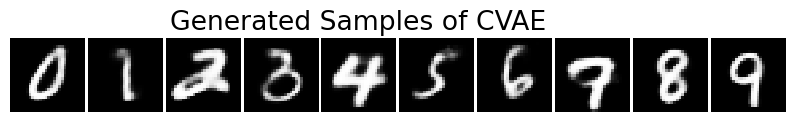

In [17]:
num_samples = 10
z = torch.randn(num_samples, latent_size)

c = torch.eye(num_samples, 10)

z = torch.cat((z,c), dim=-1).to(device='cuda')
CVAE.eval()
samples = CVAE.decoder(z).data.cpu().numpy()

fig = plt.figure(figsize=(num_samples, 1))
gspec = gridspec.GridSpec(1, num_samples)
gspec.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
    ax = plt.subplot(gspec[i])
    if i == 4:
      plt.title('Generated Samples of CVAE')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')